# پیش‌بینی به کمک مدل VARMA و VAR و مقایسه با ARIMA
(برای دو سهم بازار نیویورک)

کد به سه بخش تقسیم می‌شود:

- مدل VARMA
- مدل VAR
- مدل ARIMA

مقایسه سه مدل بالا به کمک سنجهٔ `r2_score` انجام خواهد شد.

![alt text](r2.png)

### آماده‌سازی

با ران کردن کد، متوجه شدم که خروجی دارای هشدار‌های زیادی است که پس از بررسی، تصمیم گرفتم تا مانع چاپ هشدارها در خروجی شوم تا 
خروجی تمیزتر باشد.

In [42]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

ایمپورت بستهٔ‌های یاهوفاننس و `pytse_client` برای دریافت دادهٔ مربوط به قیمت سهام:

In [44]:
import yfinance as yf       # https://pypi.org/project/yfinance/
import pytse_client as tse # https://pypi.org/project/pytse-client/

## دریافت اطلاعات

دو سهم اپل و اینتل برای این تمرین انتخاب شده‌اند، به این دلایل:

- اپل با معرفی پردازنده‌های m1 و سپس m2 در سال ۲۰۱۹ از پردازنده‌های اینتل بی‌نیاز شد.
- با موفقیت این پردازنده‌ها، سهام اپل رشد خوبی را تجربه کرد.
- سهام اینتل نیز با توجه به کاهش فروش، پایین آمد.

بنابراین به نظر می‌رسد باید رابطه‌ای منطقی میان حرکت سهام این دو شرکت وجود داشته باشد.

In [45]:
tickers_nyse = ['AAPL', 'INTC']

df_nyse = yf.download(tickers_nyse, group_by = 'ticker', start="2019-01-01", end="2022-12-15")

df_nyse.columns = [' '.join(col) for col in df_nyse.columns]
df_nyse = df_nyse[['INTC Adj Close', 'AAPL Adj Close']]
df_nyse.columns = ['intel', 'apple']

[*********************100%***********************]  2 of 2 completed


## ایمپورت بسته‌ها و توابع موردنیاز

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

## آشنایی با داده

نمودار اینتل و اپل را با هم رسم می‌کنیم. در فصل اول 2020 با همه‌گیری کرونا، کاهش در هر دو سهم مشاهده می‌شود. سپس حرکت کلی سهام اپل به بالا و سهم اینتل به پایین است.

<AxesSubplot:xlabel='Date'>

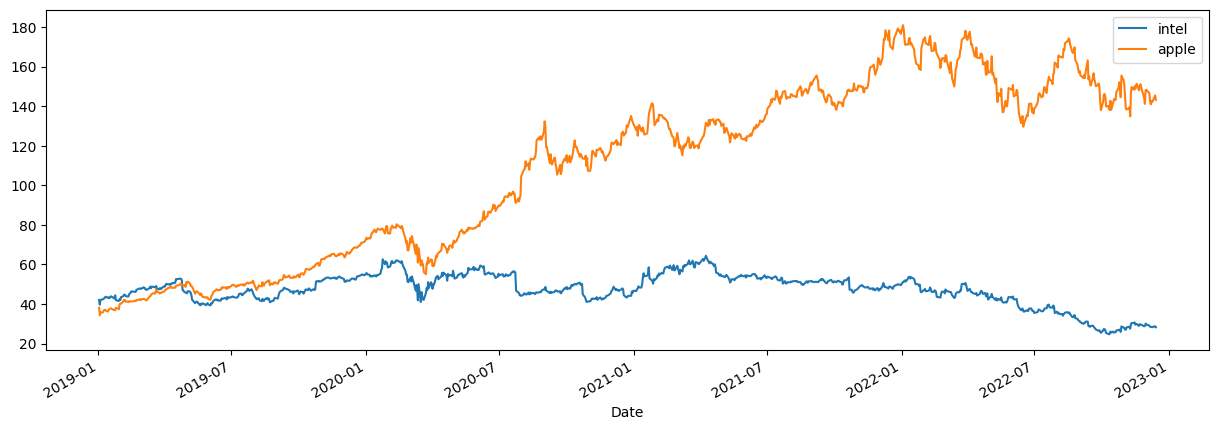

In [46]:
df_nyse[['intel', 'apple']].plot(figsize=(15, 5))

شرط کارایی مدل‌های این تمرین، مانایی سری‌های زمانی است. از آن‌جایی که سری زمانی قیمت‌ها مانا نیست، سراغ سری زمانی بازده‌ها می‌رویم.

سری زمانی بازده‌ها را به صورت زیر می‌سازیم:

In [47]:
df_nyse['intel_ret'] = np.log(df_nyse['intel']).diff()
df_nyse['apple_ret'] = np.log(df_nyse['apple']).diff()

cols = ['intel_ret', 'apple_ret']
df_nyse_returns = df_nyse.iloc[1:][cols].copy()

برای تست مدل‌ها در داده خارج از نمونه، دیتاست را به دو بخش آموزش و آزمون تقسیم می‌کنیم:

In [48]:
test_count = 24
train = df_nyse_returns[:-test_count].copy()
test = df_nyse_returns[-test_count:].copy()

train_idx = df_nyse_returns.index <= train.index[-1]
test_idx = ~train_idx

آز آنجاییکه تعداد پارامترهای مدل‌های VARMA زیاد است، بهینه‌سازی این پارامترها به کمک scale کردن دیتا، بهتر صورت می‌گیرد؛ بنابراین به کمک `StandardScaler` دیتاست را scale می‌کنیم:

In [50]:
scaler = StandardScaler()
train[cols] = scaler.fit_transform(train)
test[cols] = scaler.transform(test)

df_nyse_returns.loc[train_idx, :] = train
df_nyse_returns.loc[test_idx, :] = test

برای یافتن کاندید‌های مقادیر p و q توابع acf و pacf سری بازده‌ها را رسم می‌کنیم.

با توجه به این نمودارها و آزمایش و خطا، مقدار p برابر 21 و مقدار q برابر 1 انتخاب شدند:

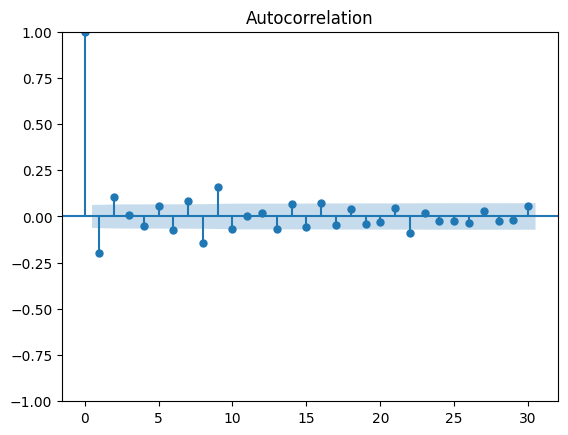

In [11]:
plot_acf(train['intel_ret']);

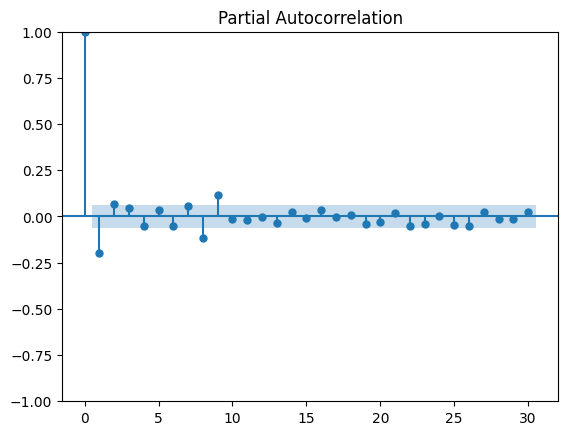

In [12]:
plot_pacf(train['intel_ret']);

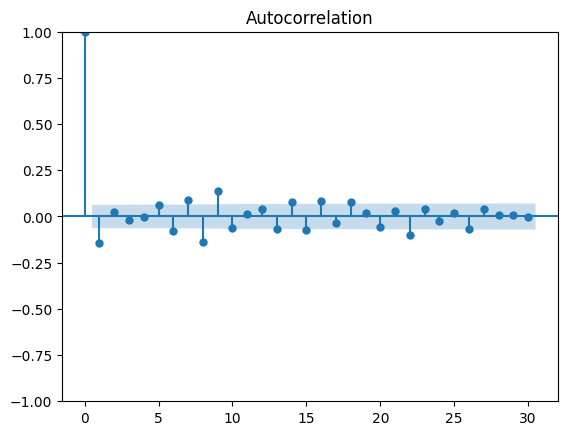

In [13]:
plot_acf(train['apple_ret']);

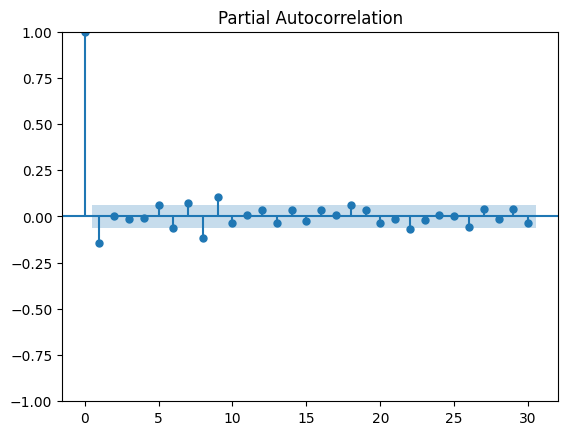

In [14]:
plot_pacf(train['apple_ret']);

پیش از شروع مدل‌سازی‌ها، از مانایی سری زمانی بازده‌ها اطمینان حاصل می‌کنیم. نتیجه آن‌که هر دو سری زمانی، در بازهٔ اطمینان ۹۹ درصد مانا هستند:

In [52]:
(adfuller(train['intel_ret'])[1] < 0.01,
adfuller(train['apple_ret'])[1] < 0.01)

(True, True)

## مدل VARMAX

به کمک کلاس VARMAX در بستهٔ `statsmodels` مدل‌سازی را با داده آموزش انجام می‌دهیم: 

In [53]:
p, q = 21, 1

t0 = datetime.now()
model = VARMAX(train, order=(p, q));
res = model.fit(maxiter=20);
print('Duration:', datetime.now() - t0)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           93     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53246D+00    |proj g|=  4.67206D-02

At iterate    5    f=  2.53090D+00    |proj g|=  1.89430D-03

At iterate   10    f=  2.53068D+00    |proj g|=  5.50977D-03

At iterate   15    f=  2.52853D+00    |proj g|=  5.21813D-02

At iterate   20    f=  2.52725D+00    |proj g|=  7.70909D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   93     20     27      1     0     0   7.709D-03   2.527D+00
  F =   2.5272483926690770     

STOP: T

مدل فیت‌شده را برای به دست آوردن مقادیر پیش‌بینی داده آزمایش به کار می‌بریم:

In [55]:
fcast = res.get_forecast(test_count)

نمودار بازده سهام اینتل را به همراه پیش‌بینی مدل در داده آموزش و آزمایش رسم می‌کنیم:

به نظر می‌رسد که مدل راضی‌کننده است.

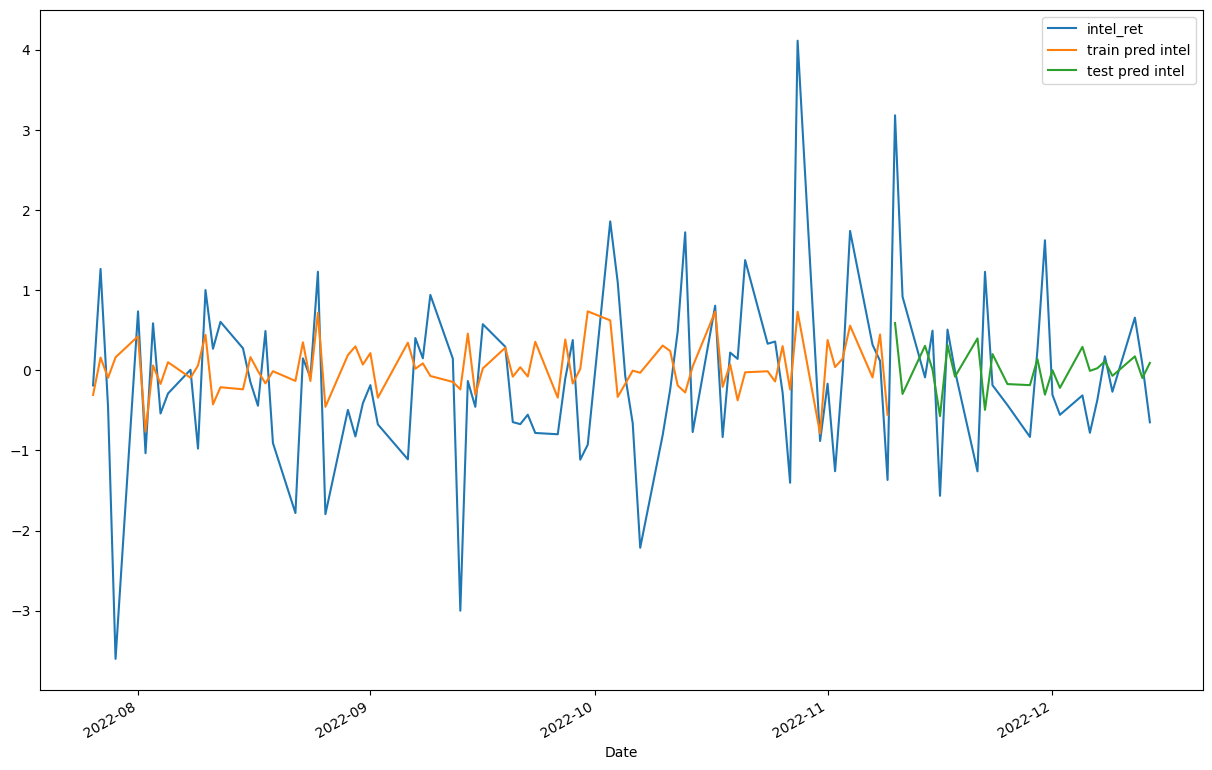

In [57]:
df_nyse_returns.loc[train_idx, 'train pred intel'] = res.fittedvalues['intel_ret']
df_nyse_returns.loc[test_idx, 'test pred intel'] = np.nan
df_nyse_returns.iloc[-test_count:]['test pred intel'] = fcast.predicted_mean['intel_ret'].values

plot_cols = ['intel_ret', 'train pred intel', 'test pred intel']
df_nyse_returns.iloc[-100:][plot_cols].plot(figsize=(15, 10));

نمودار بازده سهام اپل را به همراه پیش‌بینی مدل در داده آموزش و آزمایش رسم می‌کنیم:

به نظر می‌رسد که مدل راضی‌کننده است.

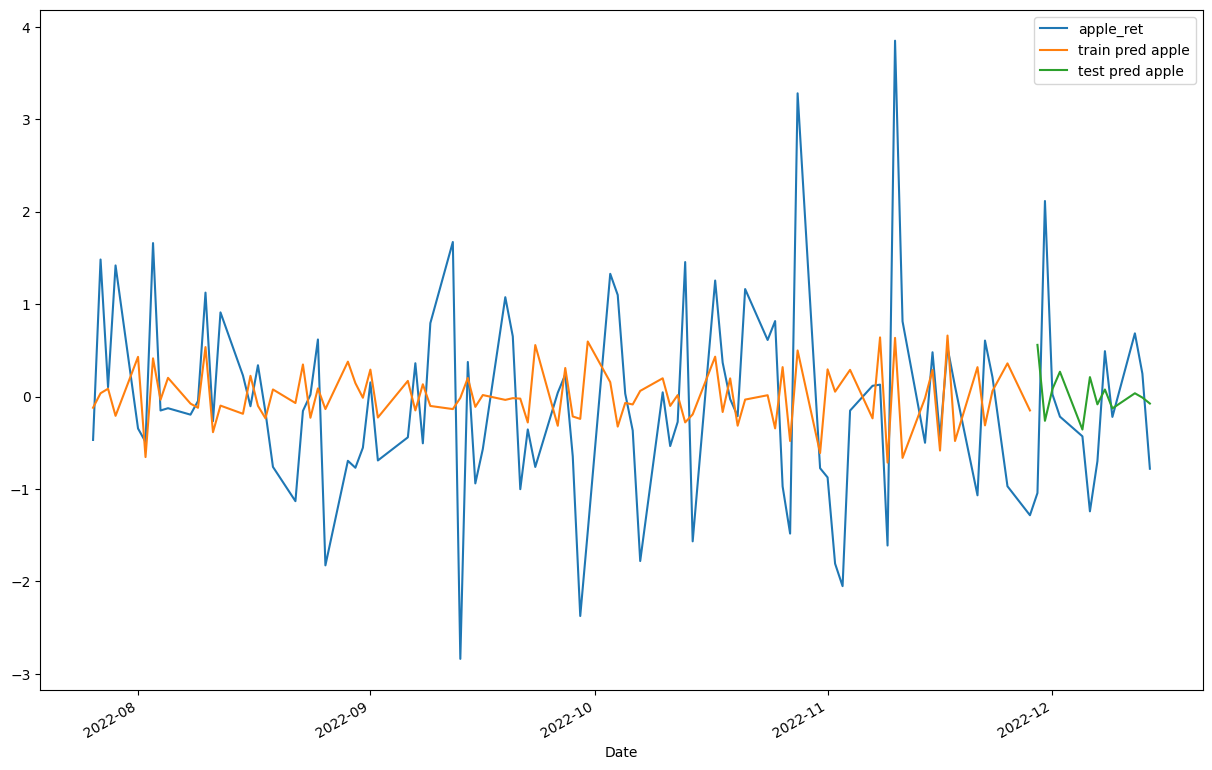

In [20]:
df_nyse_returns.loc[train_idx, 'train pred apple'] = res.fittedvalues['apple_ret']
df_nyse_returns.loc[test_idx, 'test pred apple'] = np.nan
df_nyse_returns.iloc[-test_count:]['test pred apple'] = fcast.predicted_mean['apple_ret'].values

plot_cols = ['apple_ret', 'train pred apple', 'test pred apple']
df_nyse_returns.iloc[-100:][plot_cols].plot(figsize=(15, 10));

برای ارزیابی مدل، مقدار سنجهٔ `R^2` را برای داده آموزش و آزمایش محاسبه می‌کنیم.

- هر دو سری زمانی در دادهٔ آموزش، عملکرد ضعیف اما قابل قبولی داشتند.
- در دادهٔ آزمایش، با توجه به اینکه مقدار `R^2` به صفر نزدیک هستند، می‌توان نتیجه گرفت که پیش‌بینی این مدل تفاوت زیادی با میانگین داده واقعی آزمایش ندارد. از آن‌جایی‌که مدل توانسته بسیار نزدیک به میانیگن پیش‌بینی کند، می‌توانیم بگوییم که مدل عملکرد قابل قبولی دارد چون پیش‌بینی میانیگن خود کاری دشوار است.

In [59]:
for col in cols:
    print()
    print(col, '=>')
    y_true = df_nyse_returns.loc[train_idx, col]
    y_pred = res.fittedvalues[col]
    print("Train R^2:", r2_score(y_true, y_pred))

    y_true = df_nyse_returns.loc[test_idx, col]
    y_pred = fcast.predicted_mean[col]
    print("Test R^2:", r2_score(y_true, y_pred))


intel_ret =>
Train R^2: 0.13225626291526826
Test R^2: 0.038493490941607256

apple_ret =>
Train R^2: 0.10189890133405355
Test R^2: 0.0020704162236194756


## مدل VAR

به کمک کلاس VAR در بستهٔ `statsmodel` مدل‌سازی را بر روی دادهٔ آموزش انجام می‌دهیم و پیش‌بینی‌ها را برای دادهٔ آزمون محاسبه می‌کنیم:

In [60]:
model = VAR(train)
results = model.fit(maxlags=20, ic='aic')
lag_order = results.k_ar

prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, test_count)

نمودار بازده سهام اینتل را به همراه پیش‌بینی مدل در داده آموزش و آزمایش رسم می‌کنیم:

به نظر می‌رسد که مدل راضی‌کننده است.

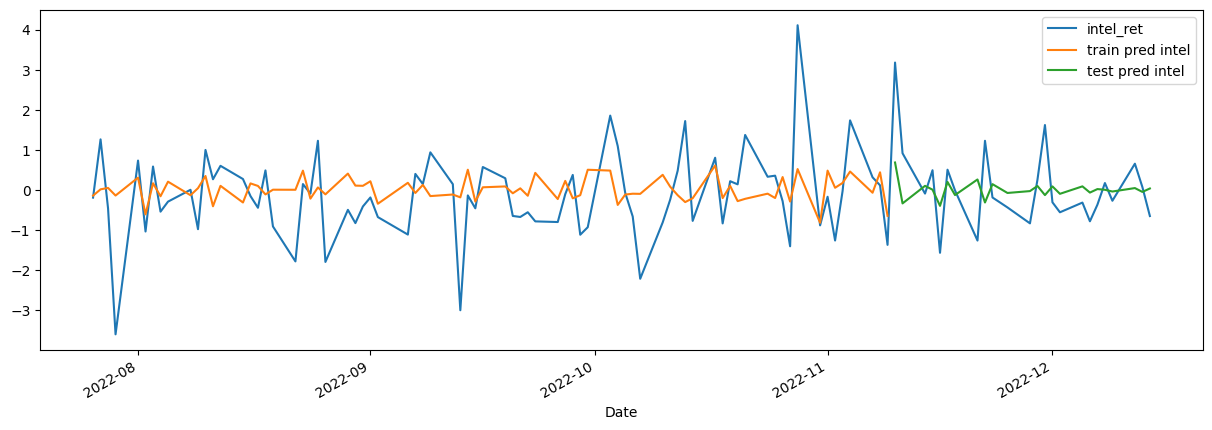

In [61]:
df_nyse_returns.loc[train_idx, 'train pred intel'] = results.fittedvalues['intel_ret']
df_nyse_returns.loc[test_idx, 'test pred intel'] = fcast[:, 0]
plot_cols = ['intel_ret', 'train pred intel', 'test pred intel']
df_nyse_returns[-100:][plot_cols].plot(figsize=(15, 5));

نمودار بازده سهام اپل را به همراه پیش‌بینی مدل در داده آموزش و آزمایش رسم می‌کنیم:

به نظر می‌رسد که مدل راضی‌کننده است.

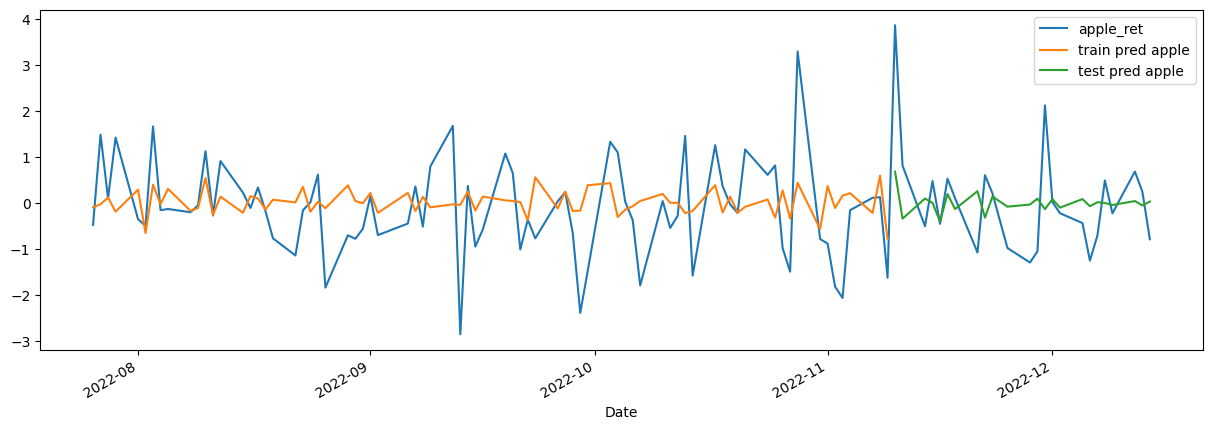

In [62]:
df_nyse_returns.loc[train_idx, 'train pred apple'] = results.fittedvalues['apple_ret']
df_nyse_returns.loc[test_idx, 'test pred apple'] = fcast[:, 0]
plot_cols = ['apple_ret', 'train pred apple', 'test pred apple']
df_nyse_returns[-100:][plot_cols].plot(figsize=(15, 5));

برای ازریابی مدل، سنجهٔ `R^2` را برای دادهٔ آموزش و آزمایش محاسبه می‌کنیم:

- در دادهٔ آزمایش، عملکرد مدل همانند مدل VARMA قابل قبول است.
- در دادهٔ آموزش، عملکرد همانند دادهٔ آموزش است و از مدل VARMA بهتر است.

In [63]:
y_pred = df_nyse_returns.loc[train_idx, 'train pred intel']
y_true = df_nyse_returns.loc[train_idx, 'intel_ret']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("intel train R^2:", r2_score(y_true, y_pred))

y_pred = df_nyse_returns.loc[test_idx, 'test pred intel']
y_true = df_nyse_returns.loc[test_idx, 'intel_ret']
print('intel test r^2:', r2_score(y_true, y_pred))

intel train R^2: 0.10243593855250488
intel test r^2: 0.10563207167376498


برای ازریابی مدل، سنجهٔ `R^2` را برای دادهٔ آموزش و آزمایش محاسبه می‌کنیم:

- در دادهٔ آزمایش، عملکرد مدل همانند مدل VARMA قابل قبول است.
- در دادهٔ آموزش، عملکرد همانند دادهٔ آموزش است و از مدل VARMA بهتر است.

In [64]:
y_pred = df_nyse_returns.loc[train_idx, 'train pred apple']
y_true = df_nyse_returns.loc[train_idx, 'apple_ret']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("apple train R^2:", r2_score(y_true, y_pred))

y_pred = df_nyse_returns.loc[test_idx, 'test pred apple']
y_true = df_nyse_returns.loc[test_idx, 'apple_ret']
print('apple test r^2:', r2_score(y_true, y_pred))

apple train R^2: 0.07973059223226697
apple test r^2: 0.0915613522332609


# مدل ARIMA

مدل آریما را به عنوان Baseline برای مقایسه دو مدل پیشین در نظر می‌گیریم:

مرتبه‌های p و q را همانند مدل VARMAX انتخاب می‌کنیم. 

پس از مدل‌سازی، سنجهٔ `R^2` را برای داده آموزش و آزمایش محاسبه می‌کنیم.

- هر دو سهام در دادهٔ آموزش نتیجهٔ قابل قبولی دارند.
- هر دو سهام در دادهٔ آزمایش، بهتر از مدل VARMAX و بدتر از مدل VAR عمل کرده‌اند.

In [66]:
for col in cols:
    model = ARIMA(train[col], order=(p, 0, q))
    res = model.fit()
    fcast = res.get_forecast(test_count)
    y_train = df_nyse_returns.loc[train_idx, col]
    y_test = df_nyse_returns.loc[test_idx, col]
    print(f"{col} train R^2:", r2_score(y_train, res.fittedvalues))
    print(f"{col} test R^2:", r2_score(y_test, fcast.predicted_mean))
    print()

intel_ret train R^2: 0.08648978712981192
intel_ret test R^2: 0.08681979990208843

apple_ret train R^2: 0.07260530461415926
apple_ret test R^2: 0.03762420844177583



## نتیجه‌گیری

مدل VARMA از نظر سنجهٔ `R^2` بدترین عملکرد و مدل VAR بهترین عملکرد را داشت.

از آن‌جاییکه مدل VARMA در واقع مدل VAR را نیز در خود دارد، دلایل زیر را می‌توان برای عملکرد بدتر آن عنوان کرد:

- بهینه‌سازی مرتبه‌های p و q در مدل VAR توسط خود سیستم صورت گرفت.
- فرایند آزمایش و خطا در مدل VARMA با توجه به زمان طولانی کامپایل کردن مدل و انتخاب مقادیر بهینه، سخت‌تر بود.
- برای مدل VARMA یک معیار خاص مانند AIC وجود ندارد.